# Target(e-commerce) Data Analysis - SQL + Python

Target is a globally recognized brand and a leading retailer in the United States, known for offering exceptional value, inspiration, innovation, and a unique shopping experience.

This dataset focuses on Target's operations in Brazil, covering 100,000 orders placed between 2016 and 2018. It includes detailed information on order status, pricing, payment and shipping performance, customer locations, product attributes, and customer reviews.

#### Dataset link: https://www.kaggle.com/datasets/devarajv88/target-dataset

## Tables and columns

| Table Name       | Columns                                                                                                                                                                                      |
| ---------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **customers**    | customer\_id, customer\_unique\_id, customer\_zip\_code\_prefix, customer\_city, customer\_state                                                                                             |
| **geolocation**  | geolocation\_zip\_code\_prefix, geolocation\_lat, geolocation\_lng, geolocation\_city, geolocation\_state                                                                                    |
| **order\_items** | order\_id, order\_item\_id, product\_id, seller\_id, shipping\_limit\_date, price, freight\_value                                                                                            |
| **orders**       | order\_id, customer\_id, order\_status, order\_purchase\_timestamp, order\_approved\_at, order\_delivered\_carrier\_date, order\_delivered\_customer\_date, order\_estimated\_delivery\_date |
| **payments**     | order\_id, payment\_sequential, payment\_type, payment\_installments, payment\_value                                                                                                         |
| **products**     | product\_id, product\_category, product\_name\_length, product\_description\_length, product\_photos\_qty, product\_weight\_g, product\_length\_cm, product\_height\_cm, product\_width\_cm  |
| **sellers**      | seller\_id, seller\_zip\_code\_prefix, seller\_city, seller\_state                                                                                                                           |


## Relationsihps / Joins
| From         | To           | Join Key                    | Type of Info            |
| ------------ | ------------ | --------------------------- | ----------------------- |
| customers    | orders       | customer\_id                | Customer → Orders       |
| orders       | order\_items | order\_id                   | Orders → Items          |
| order\_items | products     | product\_id                 | Item → Product Details  |
| order\_items | sellers      | seller\_id                  | Item → Seller Info      |
| customers    | geolocation  | customer\_zip\_code\_prefix | Customer → Lat/Lng      |
| sellers      | geolocation  | seller\_zip\_code\_prefix   | Seller → Lat/Lng        |
| orders       | payments     | order\_id                   | Order → Payment Details |

# Install libraries if not already installed and push the data in mysql server with properly handling null values

In [1]:
#pip install mysql-connector-python
#pip install pandas
#pip install numpy
#pip install matplotlib
#pip install seaborn

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import mysql.connector
import squarify

In [ ]:
# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items.csv')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='e_commerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/nakul/Desktop/SQL Project/e-commerce project/Tables'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

## Connect again to server and define the cursor to run SQL queries

In [3]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "1234",
                            database = "e_commerce")
cur = db.cursor()

## How sql query is used in python code
#### Step 1: Writing a query of SQL in pyhton in and saving it's name as query
query = """ select distinct customer_city from customers """ 

#### Step 2:Executing the query
cur.execute(query) 

#### Step 3:fetching the output of query and saving it in name = data
data = cur.fetchall() 

#### Step 4:creating a pandas dataframe of output to view it in proper manner in python output
df = pd.DataFrame(data) 

#### Step 5:viewing the output dataframe
df 

# Basic Queries

## 1. Top 10 most frequently purchased products
### Use Cases:
- Identify best-selling products to optimize inventory and marketing campaigns.<br>
- Helps in planning promotions for high-demand items.

In [4]:
query = """SELECT oi.product_id, p.product_category,
 COUNT(oi.product_id) AS freq_purchased
FROM order_items oi
JOIN products p ON p.product_id = oi.product_id
GROUP BY oi.product_id, p.product_category
ORDER BY freq_purchased DESC
LIMIT 10;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['product_id','product_category','freq_purchased'])
df

,product_id,product_category,freq_purchased
0,aca2eb7d00ea1a7b8ebd4e68314663af,Furniture Decoration,527
1,99a4788cb24856965c36a24e339b6058,bed table bath,488
2,422879e10f46682990de24d770e7f83d,Garden tools,484
3,389d119b48cf3043d311335e499d9c6b,Garden tools,392
4,368c6c730842d78016ad823897a372db,Garden tools,388
5,53759a2ecddad2bb87a079a1f1519f73,Garden tools,373
6,d1c427060a0f73f6b889a5c7c61f2ac4,computer accessories,343
7,53b36df67ebb7c41585e8d54d6772e08,Watches present,323
8,154e7e31ebfa092203795c972e5804a6,HEALTH BEAUTY,281
9,3dd2a17168ec895c781a9191c1e95ad7,computer accessories,274


## 2. Number of sellers per state
### Use Cases:
- Understand seller distribution geographically for regional growth analysis.
- Helps in identifying underrepresented states to onboard new sellers.

In [5]:
query = """SELECT seller_state,
 COUNT(DISTINCT seller_id) AS num_sellers
FROM sellers
GROUP BY seller_state
ORDER BY num_sellers DESC;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['seller_state','num_sellers'])
df

,seller_state,num_sellers
0,SP,1849
1,PR,349
2,MG,244
3,SC,190
4,RJ,171
5,RS,129
6,GO,40
7,DF,30
8,ES,23
9,BA,19


## 3. Number of products per category
### Use Cases:
- Monitor product variety in each category to ensure balanced catalog.
- Useful for identifying categories needing expansion or curation.

In [6]:
query = """SELECT product_category,
 COUNT(*) AS total_products
FROM products
WHERE product_category IS NOT NULL
GROUP BY product_category
ORDER BY total_products DESC;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "total_products"])
df

,product_category,total_products
0,bed table bath,3029
1,sport leisure,2867
2,Furniture Decoration,2657
3,HEALTH BEAUTY,2444
4,housewares,2335
...,...,...
68,Fashion Children's Clothing,5
69,House Comfort 2,5
70,PC Gamer,3
71,insurance and services,2


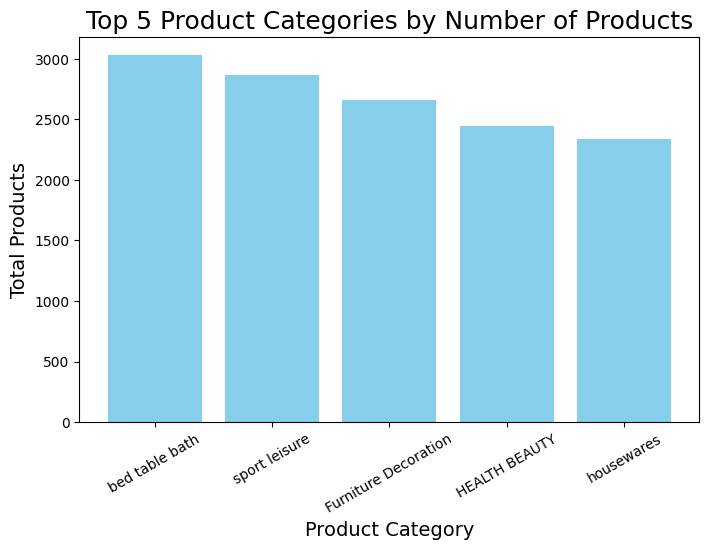

In [7]:
df = df.head(5)
plt.figure(figsize=(8,5))
plt.bar(df['product_category'], df['total_products'], color='skyblue')
plt.title('Top 5 Product Categories by Number of Products', fontsize = 18)
plt.xlabel('Product Category',fontsize = 14)
plt.ylabel('Total Products',fontsize = 14)
plt.xticks(rotation=30)
plt.show()

## 4. Total sales per category
### Use Cases:
- Evaluate revenue contribution of each product category.
- Guides pricing strategy and inventory allocation.

In [8]:
query = """-- I have included shipping cost as well.
SELECT p.product_category AS product_category, ROUND(SUM(oi.price + oi.freight_value),2) AS category_sales
FROM products p
JOIN order_items oi ON oi.product_id = p.product_id
GROUP BY p.product_category
ORDER BY category_sales DESC;
"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "category_sales"])
df

,product_category,category_sales
0,HEALTH BEAUTY,1441248.07
1,Watches present,1305541.61
2,bed table bath,1241681.72
3,sport leisure,1156656.48
4,computer accessories,1059272.40
...,...,...
69,flowers,1598.91
70,House Comfort 2,1170.58
71,cds music dvds,954.99
72,Fashion Children's Clothing,665.36


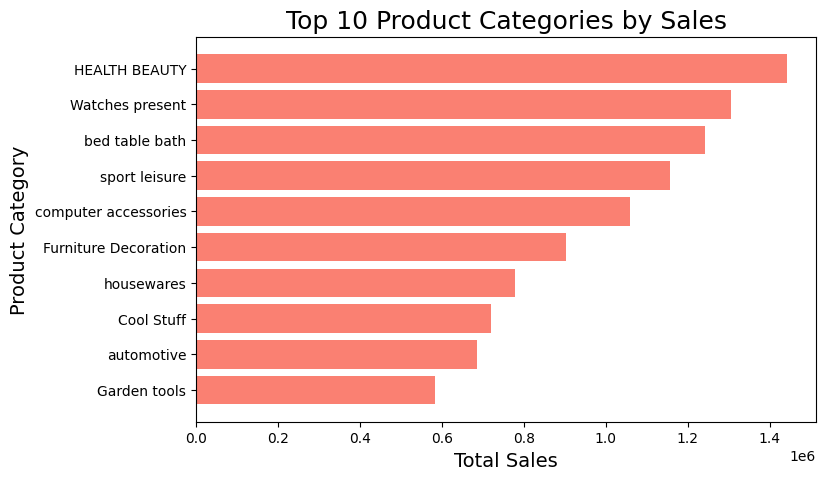

In [9]:
top10_sales_df = df.head(10)

# Horizontal bar plot
plt.figure(figsize=(8,5))
plt.barh(top10_sales_df['product_category'], top10_sales_df['category_sales'], color='salmon')
plt.title('Top 10 Product Categories by Sales', fontsize = 18)
plt.xlabel('Total Sales', fontsize = 14)
plt.ylabel('Product Category', fontsize = 14)
plt.gca().invert_yaxis()  # highest value on top
plt.show()

## 5. Percentage of orders paid in installments
### Use Cases:
- Measure customer preference for installment payments.
- Helps design financing options and promotional offers.

In [10]:
query = """SELECT
COUNT((CASE WHEN payment_installments > 1 THEN order_id END))*100/COUNT(*) AS perc_of_installment_orders
FROM payments;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["perc_of_installment_orders" ])
df

,perc_of_installment_orders
0,49.4176


# Intermediate Queries

## 1. Average delivery time by state
### Use Cases:
- Assess logistical efficiency across regions.
- Helps in targeting process improvements for slow-delivery areas.

In [11]:
query = """SELECT c.customer_state,
 AVG(datediff(o.order_delivered_customer_date, o.order_purchase_timestamp)) AS avg_delivery_time_days
FROM orders o
JOIN customers c ON c.customer_id = o.customer_id
WHERE o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state
ORDER BY avg_delivery_time_days;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_state", "avg_delivery_time_days"])
df

,customer_state,avg_delivery_time_days
0,SP,8.7005
1,PR,11.9380
2,MG,11.9465
3,DF,12.8990
4,SC,14.9075
5,RJ,15.2377
6,RS,15.2485
7,GO,15.5360
8,MS,15.5449
9,ES,15.7238


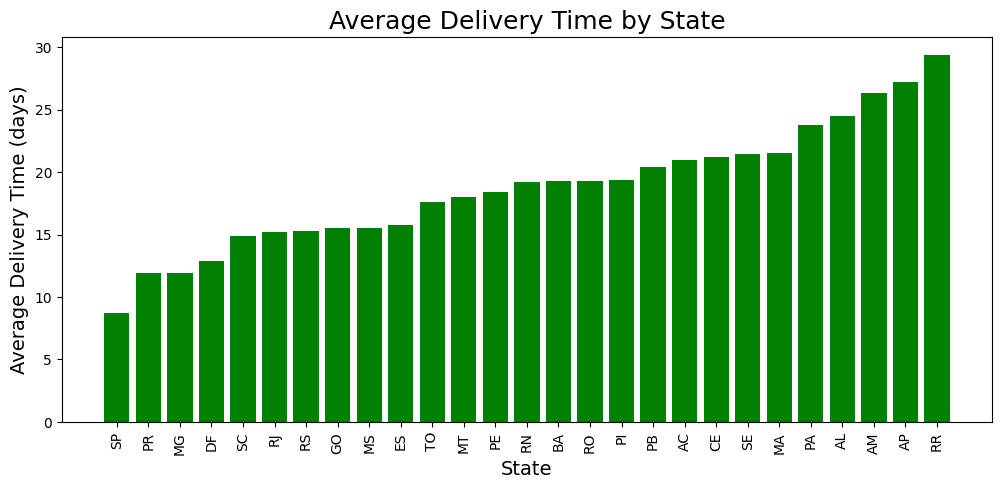

In [12]:
plt.figure(figsize=(12,5))
plt.bar(df['customer_state'], df['avg_delivery_time_days'], color='green')
plt.title('Average Delivery Time by State', fontsize = 18)
plt.xlabel('State', fontsize = 14)
plt.ylabel('Average Delivery Time (days)', fontsize = 14)
plt.xticks(rotation=90)
plt.show()

## 2. Top 5 product categories with highest return rate
### Use Cases:
- Identify categories prone to returns to improve quality or descriptions.
- Supports customer satisfaction initiatives and supplier management.

#### To get different order status to decide which comes under returns.

In [13]:
query = """-- To get different order status to decide which comes under returns.
SELECT DISTINCT order_status,
 COUNT(*) AS num_orders
FROM orders
GROUP BY order_status;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["order_status", "num_orders"])
df

,order_status,num_orders
0,delivered,96478
1,invoiced,314
2,shipped,1107
3,processing,301
4,unavailable,609
5,canceled,625
6,created,5
7,approved,2


#### For this analysis, assuming all order status other than delivered as returns/not delivered.

In [14]:
query = """-- For this analysis, assuming all order status other than delivered as returns/not delivered.
SELECT p.product_category AS top_return_product_category,
 CONCAT(ROUND(COUNT(CASE WHEN o.order_status <> 'delivered' THEN 1 END)*100/ COUNT(*),2),'%') AS return_rate
FROM products p
JOIN order_items oi ON oi.product_id = p.product_id
JOIN orders o ON o.order_id = oi.order_id
WHERE p.product_category IS NOT NULL
GROUP BY p.product_category
ORDER BY COUNT(CASE WHEN o.order_status <> 'delivered' THEN 1 END)/ COUNT(*) DESC -- need for this instead return_rate in ORDER BY is because with concat of % retun_rate becomes string and hence sorts incorrectly
LIMIT 5;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["top_return_product_category", "return_rate"])
df

,top_return_product_category,return_rate
0,Fashion Children's Clothing,12.50%
1,PC Gamer,11.11%
2,Kitchen portable and food coach,6.67%
3,Fashion Women's Clothing,6.25%
4,Art,5.74%


### Pie Chart for this

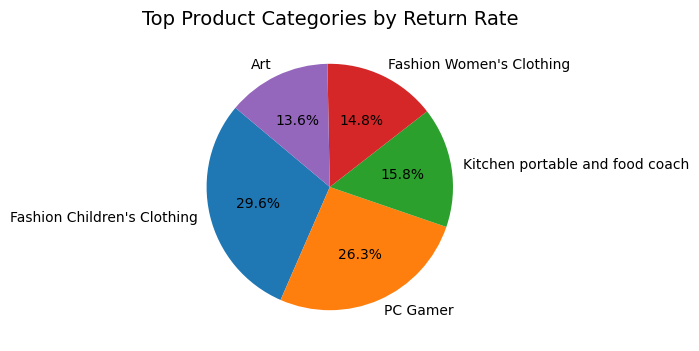

In [15]:
# Convert return_rate to numeric
df['return_rate_numeric'] = df['return_rate'].str.rstrip('%').astype(float)

# Pie chart
plt.figure(figsize=(4,4))
plt.pie(
    df['return_rate_numeric'], 
    labels=df['top_return_product_category'],
    textprops={'fontsize': 10},
    autopct='%1.1f%%', 
    startangle=140
)
plt.title('Top Product Categories by Return Rate', fontsize = 14)
plt.show()

## 3. Relationship between installment payments and order value
### Use Cases:
- Analyze if customers pay more when using installments.
- Helps tailor financing and marketing strategies for high-value orders.

#### Note: Understanding Multiple Payment Methods per Order

In the `payments` table, **one order (`order_id`) can have multiple rows**, but these are **not different installments**.  
Instead, they represent **different payment types** chosen by the customer, e.g.:

- Credit card + multiple vouchers  
- UPI + multiple vouchers  

Even if the payment was made in **one installment (full payment at once)**, the table will have multiple rows for that order.  

To better understand this, run the following query to see the **total payment per order** and the **number of payment records per order**:

```sql
SELECT *,
       COUNT(*) OVER(PARTITION BY order_id) AS count_order_id,
       SUM(payment_value) OVER(PARTITION BY order_id) AS total_payment_for_order_id
FROM payments
ORDER BY count_order_id DESC, order_id, payment_sequential; 

-- matching any order in order_items
SELECT * FROM order_items WHERE order_id = 'fa65dad1b0e818e3ccc5cb0e39231352';
-- Now the query

In [16]:
query = """WITH order_payments AS (
 SELECT order_id,
 -- Handling 2 outlier rows with '0' installments and treating them as '1'
 CASE WHEN MAX(payment_installments) = 0 THEN 1
 ELSE MAX(payment_installments)
 END AS installments,
 SUM(payment_value) AS total_payment
 FROM payments
 GROUP BY order_id
)
SELECT installments,
 ROUND(AVG(total_payment), 2) AS avg_order_value,
 COUNT(order_id) AS 'num_orders'
FROM order_payments
GROUP BY installments
ORDER BY installments;
"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["installments", "avg_order_value","num_orders"])
print("Handling 2 outlier rows with '0' installments and treating them as '1' installment")
print(" ")
df

Handling 2 outlier rows with '0' installments and treating them as '1' installment
 


,installments,avg_order_value,num_orders
0,1,121.04,48270
1,2,129.12,12363
2,3,144.36,10429
3,4,165.06,7070
4,5,184.89,5227
5,6,211.59,3908
6,7,189.34,1622
7,8,309.77,4251
8,9,204.58,644
9,10,418.75,5315


### Calculating correlation coefficient for the same.

In [17]:
import numpy as np
arr1 = df["installments"]
arr2 = df["avg_order_value"]

a = np.corrcoef([arr1,arr2])
print(f"The correlation coefficient is \033[1m{round(a[0][-1],3)}\033[0m." )

The correlation coefficient is 0.57.


- Hence it can be said that there exists a **weak positive** correlation between average order value and number of installments.

## 4. Average number of products per order by customer state
### Use Cases:
- Understand purchasing patterns regionally to optimize bundling.
- Supports logistics planning and targeted promotions.

In [18]:
query = """WITH state_order_items AS (
 SELECT c.customer_state, oi.order_id,
 COUNT(*) AS num_items
 FROM order_items oi
 JOIN orders o ON o.order_id = oi.order_id
 JOIN customers c ON c.customer_id = o.customer_id
 GROUP BY c.customer_state, oi.order_id
)
SELECT customer_state,
 AVG(num_items) AS avg_items_per_order
FROM state_order_items
GROUP BY customer_state
ORDER BY avg_items_per_order DESC;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_state", "avg_items_per_order"])
df.head(10)

,customer_state,avg_items_per_order
0,AP,1.2059
1,MT,1.1683
2,GO,1.1624
3,SC,1.1561
4,MS,1.1551
5,PR,1.1485
6,RS,1.1478
7,SP,1.1468
8,RJ,1.1424
9,MG,1.1373


## 5. Percentage of revenue contributed by each product category
### Use Cases:
- Identify high-revenue categories for strategic focus.
- Helps prioritize marketing and inventory for profitable categories.

In [19]:
query = """SELECT p.product_category,
 ROUND(SUM(oi.price)*100/(SELECT SUM(price) FROM order_items),2) AS perc_contribution_in_sales
FROM order_items oi
JOIN products p ON p.product_id = oi.product_id
GROUP BY p.product_category
ORDER BY perc_contribution_in_sales DESC;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category", "perc_contribution_in_sales"])
df

,product_category,perc_contribution_in_sales
0,HEALTH BEAUTY,9.26
1,Watches present,8.87
2,bed table bath,7.63
3,sport leisure,7.27
4,computer accessories,6.71
...,...,...
69,flowers,0.01
70,House Comfort 2,0.01
71,cds music dvds,0.01
72,Fashion Children's Clothing,0.00


### Bar Chart for top 20 categories

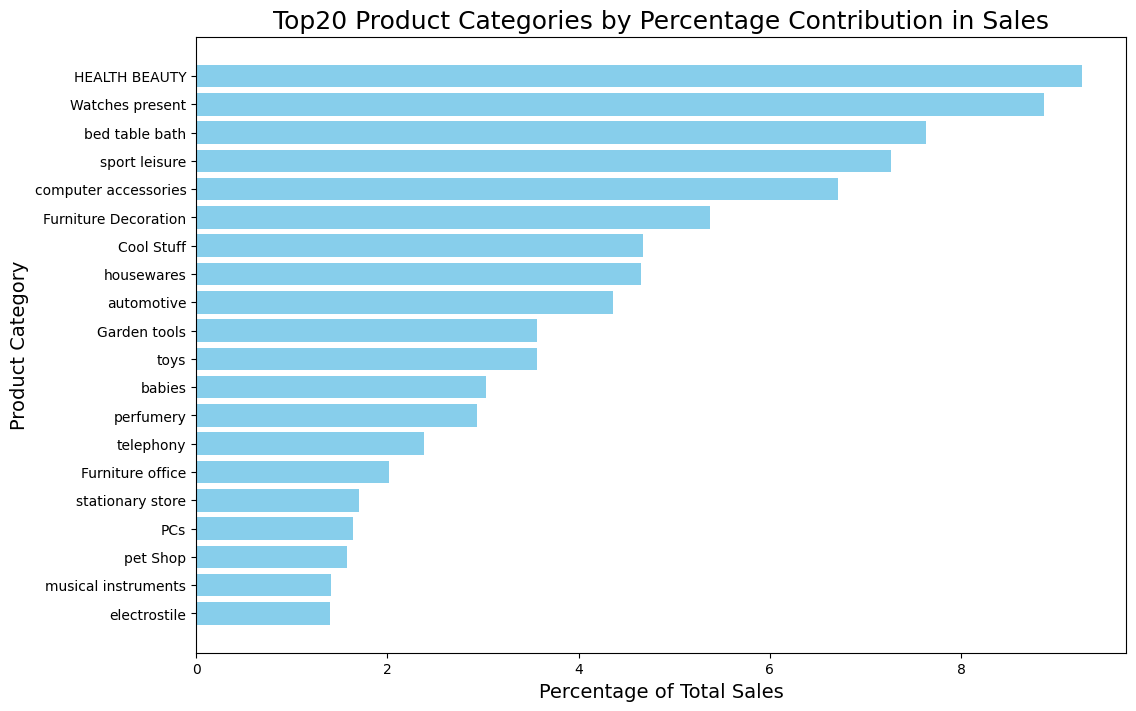

In [20]:
df = df.dropna(subset=['product_category'])
df = df.head(20)
plt.figure(figsize=(12,8))
plt.barh(df['product_category'], df['perc_contribution_in_sales'], color='skyblue')
plt.title('Top20 Product Categories by Percentage Contribution in Sales', fontsize = 18)
plt.xlabel('Percentage of Total Sales', fontsize = 14)
plt.ylabel('Product Category', fontsize = 14)
plt.gca().invert_yaxis()
plt.show()

# Advance Queries

## 1. Distribute orders across spend tiers (Very Low, Low, Medium, High, Very High)
### Use Cases:
- Segment customers by spending to inform loyalty programs.
- Helps design tiered promotions or reward strategies.

#### Let's create a grouped frequency distribution table first to get appropriate spending groups

In [21]:
#To handle error: Expression #1 of SELECT list is not in GROUP BY clause and contains nonaggregated column
query1 = """SET SESSION sql_mode = (SELECT REPLACE(@@sql_mode,'ONLY_FULL_GROUP_BY',''));
"""
cur.execute(query1)
data = cur.fetchall()

In [22]:
query = """WITH order_totals AS (
 SELECT o.order_id,
 SUM(p.payment_value) AS total_order_value
 FROM orders o
 JOIN payments p ON o.order_id = p.order_id
 WHERE o.order_status = 'delivered'
 GROUP BY o.order_id
)
SELECT
 CONCAT(FLOOR(total_order_value/100)*100, '-',
FLOOR(total_order_value/100)*100 + 99) AS value_range,
 COUNT(*) AS order_count
FROM order_totals
GROUP BY FLOOR(total_order_value/100)
ORDER BY FLOOR(total_order_value/100)
;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["value_range", "order_count"])
df

,value_range,order_count
0,0-99,45917
1,100-199,31018
2,200-299,9637
3,300-399,4073
4,400-499,1756
5,500-599,996
6,600-699,825
7,700-799,490
8,800-899,409
9,900-999,249


#### On basis of above table clustering orders into 5 tiers as :- 

In [23]:
query = """WITH order_totals AS (
 SELECT o.order_id,
 SUM(p.payment_value) AS total_order_value
 FROM orders o
 JOIN payments p ON o.order_id = p.order_id
 WHERE o.order_status = 'delivered'
 GROUP BY o.order_id
),
order_tiers AS (
 SELECT order_id,
 CASE
 WHEN total_order_value < 50 THEN 'Very Low'
 WHEN total_order_value BETWEEN 50 AND 100 THEN 'Low'
 WHEN total_order_value BETWEEN 100 AND 300 THEN 'Medium'
 WHEN total_order_value BETWEEN 300 AND 500 THEN 'High'  ELSE 'Very High'
 END AS spend_tier
 FROM order_totals
)
SELECT spend_tier,
 COUNT(*) AS order_count,
 CONCAT(ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2),'%') AS percentage_distribution
FROM order_tiers
GROUP BY spend_tier
ORDER BY -- custom sorting
 CASE spend_tier
 WHEN 'Very Low' THEN 1
 WHEN 'Low' THEN 2
 WHEN 'Medium' THEN 3
 WHEN 'High' THEN 4
 WHEN 'Very High' THEN 5
 END;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["spend_tier", "order_count","percentage_distribution"])
df

,spend_tier,order_count,percentage_distribution
0,Very Low,16451,17.05%
1,Low,29469,30.55%
2,Medium,40652,42.14%
3,High,5829,6.04%
4,Very High,4076,4.22%


### Treemap for same

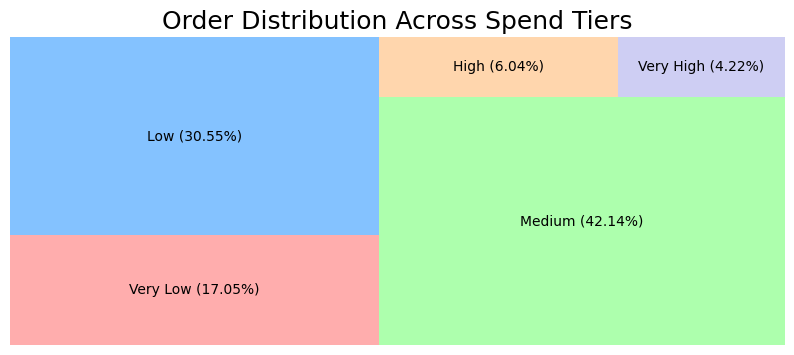

In [24]:
# Convert percentage strings to numeric
df['percentage_numeric'] = df['percentage_distribution'].str.rstrip('%').astype(float)

# Treemap
plt.figure(figsize=(10,4))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']  # custom colors
squarify.plot(
    sizes=df['percentage_numeric'],
    label=df['spend_tier'] + ' (' + df['percentage_distribution'] + ')',
    color=colors,
    alpha=0.8
)
plt.title('Order Distribution Across Spend Tiers', fontsize = 18)
plt.axis('off')  # remove axes for cleaner look
plt.show()

## 2. Top 5 sellers’ market share per category
### Use Cases:
- Identify dominant sellers in each category for competitive analysis.
- Supports partnership and performance evaluation decisions.

In [25]:
query = """WITH seller_category_sales AS(
 SELECT p.product_category, oi.seller_id,
 ROUND(SUM(oi.price + oi.freight_value),2) AS seller_category_sale,  DENSE_RANK() OVER(PARTITION BY p.product_category ORDER BY SUM(oi.price + oi.freight_value) DESC) AS seller_rank
 FROM order_items oi
 JOIN products p ON p.product_id = oi.product_id
 WHERE p.product_category IS NOT NULL
 GROUP BY p.product_category, oi.seller_id
)
SELECT product_category, seller_id, seller_category_sale,
 seller_rank,
 ROUND(seller_category_sale*100/SUM(seller_category_sale) OVER(PARTITION BY product_category),2) AS market_share_perc
FROM seller_category_sales
WHERE seller_rank <= 5
ORDER BY product_category, seller_category_sale DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product_category", "seller_id", "seller_category_sale","seller_rank","market_share_perc"])
df

,product_category,seller_id,seller_category_sale,seller_rank,market_share_perc
0,Agro Industria e Comercio,e59aa562b9f8076dd550fcddf0e73491,33803.97,1,54.38
1,Agro Industria e Comercio,6bd69102ab48df500790a8cecfc285c2,8359.02,2,13.45
2,Agro Industria e Comercio,f08a5b9dd6767129688d001acafc21e5,7796.21,3,12.54
3,Agro Industria e Comercio,2528744c5ef5d955adc318720a94d2e7,6508.70,4,10.47
4,Agro Industria e Comercio,31ae0774c17fabd06ff707cc5bde005f,5690.23,5,9.15
...,...,...,...,...,...
343,Watches present,4869f7a5dfa277a7dca6462dcf3b52b2,218530.99,1,26.74
344,Watches present,fa1c13f2614d7b5c4749cbc52fecda94,202053.47,2,24.73
345,Watches present,7e93a43ef30c4f03f38b393420bc753a,175659.49,3,21.50
346,Watches present,6560211a19b47992c3666cc44a7e94c0,123514.85,4,15.12


## 3. Month-on-month growth rate of total sales
### Use Cases:
- Monitor sales trends over time to detect growth or decline.
- Helps evaluate marketing campaigns and seasonality effects.

In [26]:
query = """WITH monthly_sales AS (
SELECT
 YEAR(o.order_purchase_timestamp) AS year,
 MONTH(o.order_purchase_timestamp) AS month_num,
 MONTHNAME(o.order_purchase_timestamp) AS month,
 ROUND(SUM(p.payment_value),2) AS monthly_sales
FROM orders o
JOIN payments p ON p.order_id = o.order_id
GROUP BY year, month_num, month
ORDER BY year, month_num
)
SELECT year, month, monthly_sales,
 LAG(monthly_sales,1) OVER(ORDER BY year, month_num) AS prev_month_sale,
 ROUND((monthly_sales - LAG(monthly_sales,1) OVER(ORDER BY year, month_num))*100/LAG(monthly_sales,1) OVER(ORDER BY year, month_num),2) AS  Mom_growth
 FROM monthly_sales;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year", "month","monthly_sales","prev_month_sale","Mom_growth"])
df

,year,month,monthly_sales,prev_month_sale,Mom_growth
0,2016,September,252.24,NaN,NaN
1,2016,October,59090.48,252.24,23326.29
2,2016,December,19.62,59090.48,-99.97
3,2017,January,138488.04,19.62,705751.38
4,2017,February,291908.01,138488.04,110.78
5,2017,March,449863.60,291908.01,54.11
6,2017,April,417788.03,449863.60,-7.13
7,2017,May,592918.82,417788.03,41.92
8,2017,June,511276.38,592918.82,-13.77
9,2017,July,592382.92,511276.38,15.86


### A line chart for MoM Growth trend

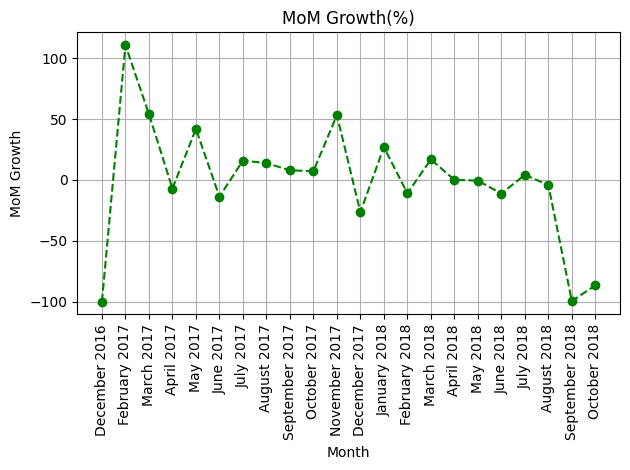

In [27]:
#attaching year and month first in dataframe as a combined column
df['month_label'] = df['month'] + ' ' + df['year'].astype(str)

# to exclude outliers, filtering the dataframe
filtered_df = df[df['Mom_growth'] <= 150].copy()

# Create combined month labels
filtered_df['month_label'] = filtered_df['month'] + ' ' + filtered_df['year'].astype(str)

plt.plot(filtered_df['month_label'], filtered_df['Mom_growth'], color='green', marker='o', linestyle='--')

plt.xlabel('Month')
plt.ylabel('MoM Growth')
plt.title('MoM Growth(%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Cumulative sales per month per year
### Use Cases:
- Track revenue accumulation within each year for forecasting.
- Useful for financial reporting and trend visualization.

In [28]:
query = """WITH monthly_sales AS (
SELECT
 YEAR(o.order_purchase_timestamp) AS year,
 MONTH(o.order_purchase_timestamp) AS month_num,
 MONTHNAME(o.order_purchase_timestamp) AS month,
 ROUND(SUM(p.payment_value),2) AS monthly_sales
FROM orders o
JOIN payments p ON p.order_id = o.order_id
GROUP BY year, month_num, month
ORDER BY year, month_num
)
SELECT
 CONCAT(month,' ', year) AS Month,
 monthly_sales,
 ROUND(SUM(monthly_sales) OVER(PARTITION BY year ORDER BY month_num),2) AS monthly_cumulative_sales
FROM monthly_sales
ORDER BY year, month_num;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Month", "monthly_sales","monthly_cumulative_sales"])
df

,Month,monthly_sales,monthly_cumulative_sales
0,September 2016,252.24,252.24
1,October 2016,59090.48,59342.72
2,December 2016,19.62,59362.34
3,January 2017,138488.04,138488.04
4,February 2017,291908.01,430396.05
5,March 2017,449863.60,880259.65
6,April 2017,417788.03,1298047.68
7,May 2017,592918.82,1890966.50
8,June 2017,511276.38,2402242.88
9,July 2017,592382.92,2994625.80


### Dual Axis (on y-axis) Chart for cumulative sales

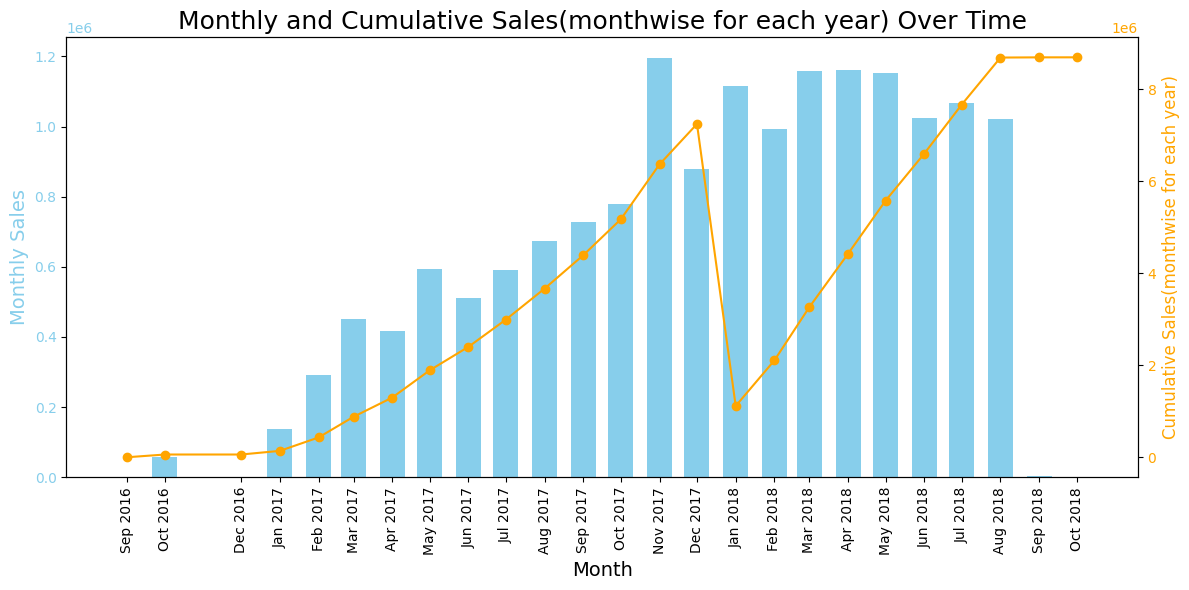

In [29]:
# Convert 'Month' to datetime
df['Month_dt'] = pd.to_datetime(df['Month'], format='%B %Y')

# Plot: bars for monthly sales, line for cumulative sales
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar: monthly sales
ax1.bar(df['Month_dt'], df['monthly_sales'], color='skyblue', label='Monthly Sales', width=20)
ax1.set_xlabel('Month', fontsize = 14)
ax1.set_ylabel('Monthly Sales', color='skyblue', fontsize = 14)
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line: cumulative sales on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df['Month_dt'], df['monthly_cumulative_sales'], color='orange', marker='o', label='Cumulative Sales')
ax2.set_ylabel('Cumulative Sales(monthwise for each year)', color='orange', fontsize = 12)
ax2.tick_params(axis='y', labelcolor='orange')

# Set all months as x-ticks
ax1.set_xticks(df['Month_dt'])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format like 'Jan 2025'

# Rotate labels for readability
ax1.tick_params(axis='x', rotation=90)

# Formatting
plt.title('Monthly and Cumulative Sales(monthwise for each year) Over Time', fontsize = 18)
fig.tight_layout()
plt.show()

## 5. Statewise delivery performance (Early, On Time, Late)
### Use Cases:
- Evaluate fulfillment efficiency regionally to improve service.
- Helps prioritize logistics improvements in states with late deliveries.

In [30]:
query = """WITH delivery_performance AS (
 SELECT c.customer_state,
 CASE
 WHEN DATEDIFF(o.order_delivered_customer_date, o.order_estimated_delivery_date) < 0 THEN 'Early'
 WHEN DATEDIFF(o.order_delivered_customer_date, o.order_estimated_delivery_date) = 0 THEN 'On Time'
 ELSE 'Late'
 END AS delivery_status
 FROM orders o
 JOIN customers c ON c.customer_id = o.customer_id
 WHERE o.order_status = 'delivered'
 AND o.order_delivered_customer_date IS NOT NULL
 AND o.order_estimated_delivery_date IS NOT NULL
)
SELECT customer_state, delivery_status,
 COUNT(*) AS orders_count,
 ROUND(COUNT(*)*100.0 / SUM(COUNT(*)) OVER(PARTITION BY customer_state), 2) AS percentage
FROM delivery_performance
GROUP BY customer_state, delivery_status
ORDER BY customer_state, delivery_status;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_state","delivery_status","orders_count","percentage"])
df

,customer_state,delivery_status,orders_count,percentage
0,AC,Early,77,96.25
1,AC,Late,3,3.75
2,AL,Early,302,76.07
3,AL,Late,85,21.41
4,AL,On Time,10,2.52
...,...,...,...,...
72,SP,Late,1820,4.49
73,SP,On Time,567,1.40
74,TO,Early,239,87.23
75,TO,Late,27,9.85


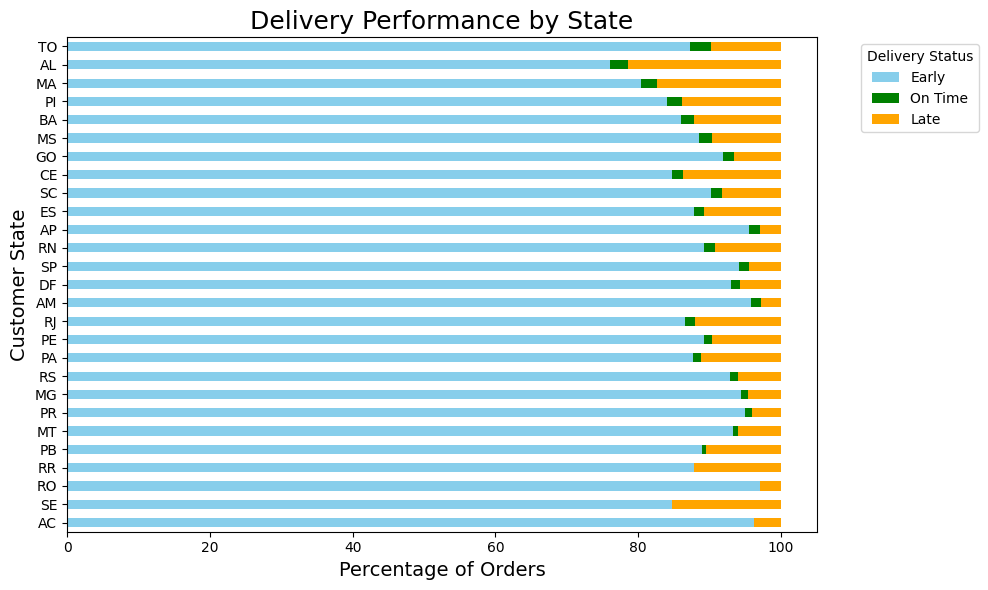

In [31]:
# Pivot data
pivot_df = df.pivot(index='customer_state', columns='delivery_status', values='percentage')

# Ensure columns exist in the desired order
for status in ['Early', 'On Time', 'Late']:
    if status not in pivot_df.columns:
        pivot_df[status] = 0

pivot_df = pivot_df[['Early', 'On Time', 'Late']]

# Fill NaN with 0 and ensure numeric
pivot_df = pivot_df.fillna(0).astype(float)

# Sort by On Time percentage for clarity
pivot_df = pivot_df.sort_values('On Time', ascending=True)

# Horizontal stacked bar chart
pivot_df.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'green', 'orange'])

plt.xlabel('Percentage of Orders', fontsize = 14)
plt.ylabel('Customer State', fontsize = 14)
plt.title('Delivery Performance by State', fontsize = 18)
plt.legend(title='Delivery Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
